# Training a Model

Now that we've got data in Hopsworks and the architecture for updating it, we can go ahead and start writing our model training data. Since we're working with time series data that has strong seasonality, I'm going to use Meta's Prophet algorithm.

Since our data is hosted on Hopsworks, we need to get it:

In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/14486
Connected. Call `.close()` to terminate connection gracefully.


In [2]:
# Load feature groups.
zip_code = '60603'  # Chicago
country_code = 'US'
city = 'Chicago'

fg_name = f'aqi_{city}_{zip_code}'.lower()

aqi_online_fg = fs.get_feature_group(fg_name, version=1)

not_features = ['date', 'lat', 'lon']

ds_query = aqi_online_fg.select_except(not_features)

In [3]:
ds_query.show(5, online=True)

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime,aqi,id
0,347.14,10.39,21.94,39.70,8.46,7.21,11.43,2.69,2020-11-28 12:00:00,1,36
1,440.60,16.99,26.39,26.82,10.97,18.80,24.32,4.37,2020-12-03 12:00:00,2,156
2,340.46,5.03,25.36,42.20,10.97,16.63,19.86,2.50,2020-12-03 16:00:00,2,160
3,273.71,0.02,14.91,41.84,5.42,11.97,13.51,0.63,2020-12-04 06:00:00,2,174
4,243.66,1.02,11.31,80.11,4.71,1.38,2.84,0.76,2020-12-05 12:00:00,2,204


Notice that the data appears to be out of order. This is ok.

We will now define some transformation functions to normalize all of our features. These transformations will be applied to the data when we create a feature view.

In [4]:
# Load the transformation function we want.
standard_scaler = fs.get_transformation_function(name="standard_scaler")

# Map features to transformation function
transformation_functions = {
    'co': standard_scaler, 
    'no': standard_scaler, 
    'no2': standard_scaler, 
    'o3': standard_scaler,
    'so2': standard_scaler, 
    'pm2_5': standard_scaler, 
    'pm10': standard_scaler, 
    'nh3': standard_scaler
}

Training data is created from feature views in Hopsworks. Feature views are logical views over sets of features. Normally they are created by joining together different feature groups. Since we only have one here though it's a little different.

In [5]:
fv_name = f'{fg_name}_fv'

try:
    feature_view = fs.get_feature_view(name=fv_name, version=1)
except: 
    feature_view = fs.create_feature_view(
    name=fv_name,
    version=1,
    description='feature view for creating training data',
    query=ds_query,
    labels=['id', 'aqi'],
    transformation_functions=transformation_functions
)

Now let's get the earliest and latest dates in the dataset to split our data into a training and testing set:

In [6]:
import datetime
import pandas as pd

newest_date = pd.to_datetime(fs.sql(f"SELECT MAX(`datetime`) FROM `{fg_name}_1`", online=True).values[0][0])
oldest_date = pd.to_datetime(fs.sql(f"SELECT MIN(`datetime`) FROM `{fg_name}_1`", online=True).values[0][0])

print(newest_date, oldest_date)

2023-01-17 20:00:00 2020-11-27 00:00:00


In [7]:
train_start = oldest_date - datetime.timedelta(minutes=1)
train_end = newest_date - datetime.timedelta(days=30)

test_start = train_end + datetime.timedelta(hours=1)
test_end = newest_date

print(train_start, train_end, test_start, test_end)

2020-11-26 23:59:00 2022-12-18 20:00:00 2022-12-18 21:00:00 2023-01-17 20:00:00


We'll give ourselves roughly 2 years of training data and 1 month of testing data. Now convert to a format Hopsworks can understand:

In [8]:
train_start_str = train_start.strftime('%Y-%m-%d %H:%M:%S')
train_end_str = train_end.strftime('%Y-%m-%d %H:%M:%S')
test_start_str = test_start.strftime('%Y-%m-%d %H:%M:%S')
test_end_str = test_end.strftime('%Y-%m-%d %H:%M:%S')

print(train_start_str, train_end_str, test_start_str, test_end_str)

2020-11-26 23:59:00 2022-12-18 20:00:00 2022-12-18 21:00:00 2023-01-17 20:00:00


In [9]:
print(f'aqi data for training {train_start} to {train_end}')

aqi data for training 2020-11-26 23:59:00 to 2022-12-18 20:00:00


In [10]:
# Create training datasets based event time filter
# train_d, train_d_job = feature_view.create_training_data(
#         start_time = train_start_str,
#         end_time = train_end_str,    
#         description = f'aqi data for training {train_start} to {train_end}',
#         data_format = "csv",
#         coalesce = True,
#         write_options = {'wait_for_job': False},
#     )

In [11]:
# Create testing datasets based event time filter
# test_d, test_d_job = feature_view.create_training_data(
#         start_time = test_start_str,
#         end_time = test_end_str,    
#         description = f'aqi data for testing {test_start} to {test_end}',
#         data_format = "csv",
#         coalesce = True,
#         write_options = {'wait_for_job': False},
#     )

Now that the train and test data set views have been created, we can access them like so:

In [12]:
train_x, train_y = feature_view.get_training_data(1)
test_x, test_y = feature_view.get_training_data(2)

In [13]:
train_x.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime
0,-0.744854,-0.294919,-0.845750,1.294387,-0.356564,-0.147238,-0.185984,-0.485533,2022-10-23T18:00:00.000Z
1,-0.727361,-0.308482,-0.807231,1.253209,-0.370837,-0.099050,-0.115664,-0.439192,2022-10-23T20:00:00.000Z
2,-0.639949,-0.306395,-0.614136,0.161576,-0.399385,-0.284917,-0.300254,-0.236973,2022-10-23T09:00:00.000Z
3,-0.762347,-0.308482,-0.948801,0.820414,-0.889456,-0.165308,-0.182603,-0.325444,2022-10-23T01:00:00.000Z
4,-0.709868,-0.308482,-0.721689,0.243931,-0.413659,-0.300406,-0.311749,-0.270676,2022-10-23T08:00:00.000Z


Now we have a dataframe for each train and test x and y! Simple!

In [14]:
train_y.head()

,aqi,id
0,2,16576
1,2,16578
2,1,16567
3,2,16559
4,1,16566


In [15]:
# check that we have the right time period for train and test
print(train_x['datetime'].min(), train_x['datetime'].max(), test_x['datetime'].min(), test_x['datetime'].max())

2020-11-27T00:00:00.000Z 2022-12-18T08:00:00.000Z 2022-12-18T09:00:00.000Z 2023-01-17T08:00:00.000Z


In [16]:
train_x.dtypes

co          float64
no          float64
no2         float64
o3          float64
so2         float64
pm2_5       float64
pm10        float64
nh3         float64
datetime     object
dtype: object

In [17]:
# need to convert datetime from strings
train_x.datetime = pd.to_datetime(train_x.datetime)
test_x.datetime = pd.to_datetime(test_x.datetime)

In [18]:
train_x.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime
0,-0.744854,-0.294919,-0.845750,1.294387,-0.356564,-0.147238,-0.185984,-0.485533,2022-10-23 18:00:00+00:00
1,-0.727361,-0.308482,-0.807231,1.253209,-0.370837,-0.099050,-0.115664,-0.439192,2022-10-23 20:00:00+00:00
2,-0.639949,-0.306395,-0.614136,0.161576,-0.399385,-0.284917,-0.300254,-0.236973,2022-10-23 09:00:00+00:00
3,-0.762347,-0.308482,-0.948801,0.820414,-0.889456,-0.165308,-0.182603,-0.325444,2022-10-23 01:00:00+00:00
4,-0.709868,-0.308482,-0.721689,0.243931,-0.413659,-0.300406,-0.311749,-0.270676,2022-10-23 08:00:00+00:00


In [19]:
# data points are not in order
train_x = train_x.sort_values("datetime")
train_y = train_y.reindex(train_x.index)

test_x = test_x.sort_values("datetime")
test_y = test_y.reindex(test_x.index)

In [20]:
print(train_x['datetime'].min(), train_x['datetime'].max(), test_x['datetime'].min(), test_x['datetime'].max())

2020-11-27 00:00:00+00:00 2022-12-18 08:00:00+00:00 2022-12-18 09:00:00+00:00 2023-01-17 08:00:00+00:00


In [21]:
# need to remove time zone information in order to use prophet
train_x['datetime'] = train_x['datetime'].dt.tz_localize(None)
test_x['datetime'] = test_x['datetime'].dt.tz_localize(None)

In [22]:
print(train_x['datetime'].min(), train_x['datetime'].max(), test_x['datetime'].min(), test_x['datetime'].max())

2020-11-27 00:00:00 2022-12-18 08:00:00 2022-12-18 09:00:00 2023-01-17 08:00:00


In [23]:
train_x.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime
6687,0.269111,-0.209372,0.860090,-1.365155,-0.313742,-0.052584,0.160885,-0.199057,2020-11-27 00:00:00
6691,0.094286,-0.270925,0.585955,-1.228665,-0.328016,-0.170471,-0.009507,-0.397063,2020-11-27 01:00:00
6698,-0.063046,-0.290746,0.345837,-1.105133,-0.342290,-0.237590,-0.133244,-0.506598,2020-11-27 02:00:00
6684,-0.115525,-0.294398,0.259795,-1.074322,-0.356564,-0.236729,-0.173137,-0.536088,2020-11-27 03:00:00
6688,-0.115525,-0.292311,0.259795,-1.110316,-0.328016,-0.198868,-0.153528,-0.536088,2020-11-27 04:00:00


In [24]:
train_y.head()

,aqi,id
6687,2,0
6691,1,1
6698,1,2
6684,1,3
6688,1,4


Now we can bring in Prophet and train a model:

In [25]:
from prophet import Prophet

In [34]:
df = pd.concat([train_x.datetime, train_y['aqi']], axis=1)
df.columns = ['ds', 'y']
df = df.sort_values(by='ds')
df['ds'].min()

Timestamp('2020-11-27 00:00:00')

In [35]:
df.head()

,ds,y
6687,2020-11-27 00:00:00,2
6691,2020-11-27 01:00:00,1
6698,2020-11-27 02:00:00,1
6684,2020-11-27 03:00:00,1
6688,2020-11-27 04:00:00,1


In [51]:
m = Prophet(interval_width=0.95, changepoint_range=0.9, changepoint_prior_scale=0.1)

In [52]:
m.fit(df)

Initial log joint probability = -345.051
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95         22100   4.91842e-05       44.2478   1.035e-06       0.001      177  LS failed, Hessian reset 
      99         22100   0.000376208       41.1993           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       22100.3   0.000575308       44.6306           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       22100.3   0.000430117       167.897   9.369e-06       0.001      349  LS failed, Hessian reset 
     267       22100.4    4.5433e-05       36.2838   1.176e-06       0.001      466  LS failed, Hessian reset 
     299       22100.4   3.15256e-06       36.6682      0.9163      0.2228      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

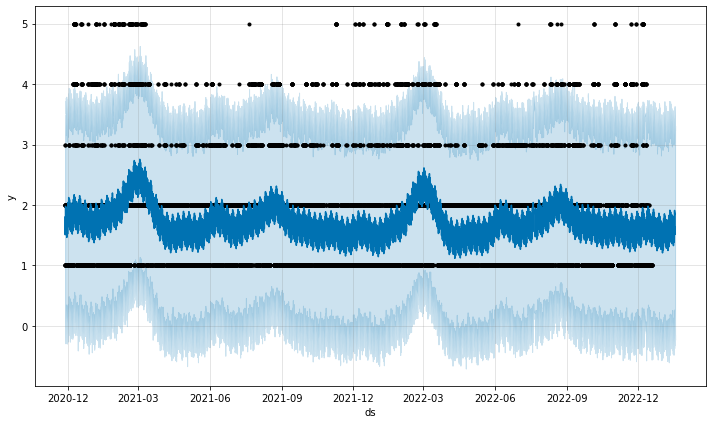

In [53]:
future = m.make_future_dataframe(periods=24*30, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

In [56]:
import xgboost as xgb

In [57]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [60]:
y_train = train_y[['aqi']]

In [61]:
reg.fit(train_x, y_train, early_stopping_rounds=50, verbose=True)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:datetime: datetime64[ns]